### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Introducción al Aprendizaje Automático

Integrantes:

- Christian Oviedo
- Francisco Correa

El objetivo de este práctico es probar distintos modelos de clasificación para evaluar la performance y la exactitud de predicción de cada modelo. 

* Utilizando el corpus normalizado en el práctico anterior, transformar el texto en vectores numéricos utilizando scikit-learn comparando los 3 modelos de vectorización. Explicar cada uno estos modelos.

* Clasificar los documentos por fuero. Trabajaremos con los siguientes modelos de clasificación de la librería scikit-learn: Logistic Regresion, Naive Bayes y SVM. En cada modelo probar distintos hiperparámetros, generar la Matriz de Confusión y la Curva ROC. Explicar los resultados obtenidos.

* Determinar y justificar cual es el modelo con mejor performance y predecir el fuero de un documento utilizando el mejor modelo.


Fecha de Entrega: 15 de agosto de 2021

Se carga el corpus normalizado en en el práctico anterior

In [1]:
#!conda install -y yellowbrick

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it



from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score

from sklearn import svm, datasets

from sklearn.ensemble import RandomForestClassifier


from collections import Counter

from functools import reduce

Esta clase permite hacer un gridsearch sobre diferentes modelos. Ver http://www.davidsbatista.net/blog/2018/02/23/model_optimization/ 

In [90]:
corpus_file_name = 'cleaned_corpus.csv'
cleaned_corpus = pd.read_csv(corpus_file_name)

In [91]:
cleaned_corpus.head()

,Unnamed: 0,text,id,classifier
0,0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,1,univoco fecha materia revista familia tribunal...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,2,juzgado juventud violencia familiar 8ª cordoba...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,4,juzg adolescencia violencia familiar 4ta cba s...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES


Generamos los sets de entrenamiento y de testing

In [92]:
X = cleaned_corpus['text']  
y = cleaned_corpus['classifier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modelos de Vectorización

Esta función recibe una lista de documentos para entrenar (X_train), una lista de documentos para hacer el testing (X_test )del modelo entrenado, y un vectorizer para transformar a vectores los documentos de entrenamiento y prueba. Devuelve dos matrices sparse donde cada fila es un vector que representa un documento.

In [93]:
def get_vectors(X_train, X_test, vectorizer):
    
    X_train_vect = vectorizer.fit_transform(X_train)
    X_text_vect = vectorizer.transform(X_test)
    
    return (X_train_vect, X_text_vect)

## Vectorización con CountVectorizer
Este esquema de vectorización es el más simple y básico. Se genera un vector que representa todas las palabras del corpus. Cada documento es representado como una instancia del vector anterior indicando la cantidad de veces que aparece cada palabra. Notar que este modelo de vectorización esta sesgado para el caso en que tengamos palabras poco frecuentes pero muy significativas para clasificar documentos y también para palabras que aparezcan 'mucho', pero que aparezca en todos los documentos. En el último caso, si tratamos de diferenciar los documentos en base a las palabras que los componen,  que las palabras aparezcan en todos ellos, no aporta información

In [94]:
count_vect = CountVectorizer()

X_train_vect , X_test_vect = get_vectors(X_train, X_test, count_vect)

X_train_vect.shape

(162, 15696)

In [95]:
print ("X_train")
print (f"Cantidad de documentos:{X_train_vect.shape[0]}, Cantidad de dimensiones por documento: {X_train_vect.shape[1]} ")

print ("X_test")
print (f"Cantidad de documentos:{X_test_vect.shape[0]}, Cantidad de dimensiones por documento: {X_test_vect.shape[1]} ")

X_train
Cantidad de documentos:162, Cantidad de dimensiones por documento: 15696 
X_test
Cantidad de documentos:81, Cantidad de dimensiones por documento: 15696 


In [96]:
#count_vect.vocabulary_


## Vectorización con TfidfVectorizer
Cuando vimos el método CountVectorizer, vimos que no es suficiente únicamente contar la cantidad de veces que aparece una palabra en un documento, puesto que no es lo mismo que esa palabra aparezca en el resto de los documentos (en este caso, la palabra no brinda información relevante) a que aparezca en un número reducido de documentos (en este caso la palabra si brinda información relevante.)
Es por eso que es necesario contar con algún método que permita hacer este tipo de distinciones a la hora de expresar documentos como vectores.

El método TF-IDF (Term Frequency – Inverse Documento Frequency) busca generar vectores que indican no solamente cuanto aparece una palabra en un documento, sino que tan frecuente es esa palabra en el resto de los documentos.

TF(palabra,documento) =  $\frac{\textrm{Número de veces que la palabra aparece en el documento}}{\textrm{Número de palabras diferentes en el documento}}$


DF(palabra,documentos) =  $\frac{\textrm{Cantidad de documentos que tienen la palabra}}{\textrm{cantidad de documentos}}$


IDF(palabra,documentos) = $ log ({\frac{\textrm{cantidad de documentos}}{\textrm{Cantidad de documentos que tienen la palabra}}})$

Notar que en IDF, cuando la cantidad de documentos que tienen la palabra, se acerca a la cantidad de documentos, el resultado de la división se acerca a 1 y por consiguiente, el logartimo a 0.

**TF - IDF = (palabra, documentos, documento) = TF (palabra, documento) $\times$ IDF (palabra, documentos)**



In [97]:
vectorizer = TfidfVectorizer()

X_train_tfidf , X_test_tfidf = get_vectors(X_train, X_test, vectorizer)


X_train_tfidf.shape

(162, 15696)

In [98]:
print ("X_train")
print (f"Cantidad de documentos:{X_train_tfidf.shape[0]}, Cantidad de dimensiones por documento: {X_train_tfidf.shape[1]} ")

print ("X_test")
print (f"Cantidad de documentos:{X_test_tfidf.shape[0]}, Cantidad de dimensiones por documento: {X_test_tfidf.shape[1]} ")

X_train
Cantidad de documentos:162, Cantidad de dimensiones por documento: 15696 
X_test
Cantidad de documentos:81, Cantidad de dimensiones por documento: 15696 


In [99]:
#vectorizer.vocabulary_

Las variables X_train_counts y X_test_counts se usan para todos los cálculos que siguen. Estas variables las igualamos a las variables que tienen los resultados de TF – IDF por ser el mejor método de vectorización de los tres analizados. En el caso de querer correr la notebook con el resultado de CountVectorizer, o Hash, descomentar las celdas correspondientes

In [100]:
X_train_counts  = X_train_tfidf
X_test_counts = X_test_tfidf

In [101]:
#X_train_counts  = X_train_vect
#X_test_counts = X_test_vect

# Clasificación usando diferentes modelos

## Curva ROC


Se puede utilizar un gráfico AUC ROC (Área bajo la curva de características operativas del receptor) para visualizar el rendimiento de un modelo entre la sensibilidad y la especificidad. La sensibilidad se refiere a la capacidad de identificar correctamente las entradas que pertenecen a la clase positiva. La especificidad se refiere a la capacidad de identificar correctamente las entradas que pertenecen a la clase negativa. Dicho de otra manera, una gráfica AUC ROC puede ayudar a identificar qué tan bien su modelo es capaz de distinguir entre clases.


En los problemas del mundo real, a menudo hay una superposición entre las clases, lo que significa que detectar todos los verdaderos negativos y verdaderos positivos puede ser desafío muchas veces de imposible solución. Se muestra a continuación una ilustración de lo que se esta comentando:


<img src="images/ROC_curve.png">



Notar que dependiendo donde se ubique el umbral de predicción, cambiará el número de TP, TN, FP y FN. Notar también que en el gráfico anterior, las distribuciones se solapan (lo que sucede con frecuencia en problemas de la vida real), lo que trae como consecuencia, tener inevitablemente FN y FP.

El tipo de problemática que quiera resolver, es el que indicará hacia donde muevo el umbral. Supongamos por ejemplo que lo que estamos tratando de clasificar es si un paciente tiene cáncer o no. Es claro que en este ejemplo, no quiero tener falsos negativos (FNwww.www). No es aceptable que a una persona que tiene cáncer, le de un diagnóstico en el cual indica que esta sana. En este caso, voy a mover el umbral de predicción hacia la izquierda de manera tal que no exista la posibilidad de generar falsos negativos (FN). Al mover el umbral de esta manera, voy a aumentar inevitablemente la cantidad de falsos positivos (FP), los cuales luego puedo descartar con estudios más específicos.

Volviendo gráfico AUC ROC, una puntuación AUC de 1 significa que el modelo puede distinguir con precisión entre las dos clases el 100% del tiempo, es decir, estamos frente a un clasificador ideal. Una puntuación de 0,5 significa que el modelo no puede determinar entre las dos clases y, en esencia, está adivinando. La curva ROC es la gráfica de la tasa de verdaderos positivos del modelo frente a la tasa de falsos positivos.



$\textrm{TPR} =  \frac{\textrm{TP}} {{\textrm{TP}}➕{\textrm{FN}} }$

$\textrm{FPR} =  \frac{\textrm{FP}} {{\textrm{FP}}➕{\textrm{TN}} }$


De lo antes indicado, entonces al momento de evaluar los modelos de clasificación, buscaremos o nos quedaremos con aquel modelo y los correspondientes híper parámetros para los cuales el área bajo la curva ROC sea lo más cercana a 1.

<img src="images/ROC_curve_values.png">

La clasificación que se solicita en la mentoria, es una clasificación multi clase, es por ello que debemos extender el concepto de curvas ROC a curvas ROC para clasificaciones multi clases

Lo que se estuvo presentando hasta el momento esta orientado a clasificaciones binarias. Como se puede hacer para llevar o reutilizar lo antes mencionado en clasificaciones multi clases. Una estrategia para lograr esto, es que las curvas ROC se pueden trazar con la metodología de usar una clase frente al resto. Utilizando uno contra el resto para cada clase, se tendrá el mismo número de curvas que clases. La puntuación AUC también se puede calcular para cada clase individualmente.


<img src="images/ROC_curve_multiclass.png">

El componente que utilizaremos para realizar la Curva ROC para clasificaciones multi clases, es el provisto por  **yellowbrick** (https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html)


ROC Multiclass: https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de

La función **test_model** recibe un modelo de clasificación (por ejemplo Naive Bayes, Regresión Logística, etc ), los sets de entrenamiento y testing, y muestra:


-	La métricas: precisión, recall, f1-score
-	La matriz de confusión
-	Curca ROC Multiclase y el AUC correspondiente

Este método usa el método plot_ROC_curve para poder visualizar la curva ROC multiclase


In [102]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest , ax , macro = True, micro = True , per_class = True):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(estimator = model , ax = ax , macro = macro, micro = micro , per_class = per_class)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    #return visualizer


def test_model(model, X_train, y_train, X_test, y_test ):
    
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_pred ))

    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.grid(False)
    ax.set_title('Confusion Matrx')

    disp =metrics.plot_confusion_matrix(model, X_test, y_test, display_labels= ["FAMILIA" ,"LABORAL" , "MENORES" , "PENAL" ], ax = ax)
    
    #disp =metrics.plot_confusion_matrix(model, X_test, y_test, display_labels= ["FAMILIA" ,"LABORAL" , "MENORES" , "PENAL" ])
    

    #disp.confusion_matrix
    
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_title('ROC')
        
    plot_ROC_curve(model = model, xtrain = X_train, ytrain = y_train, xtest = X_test, ytest = y_test , ax = ax1 )
    

Seteamos el seed para que todos los experimentos sean repetibles

In [103]:
seed = 42

Los modelos y los híper paramétros mostrados a continuación, provienen de los resultados obtenidos en el apartado **Anexo**, punto *Optimización de modelos*.  Ahí se pueden observar algunos de los modelos que se probaron, los híper parámetros utilizados y los resultados obtenidos. 

## Logistic Regression

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.92      1.00      0.96        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.60      0.75        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.95        81
         macro avg       0.98      0.90      0.93        81
      weighted avg       0.95      0.95      0.95        81



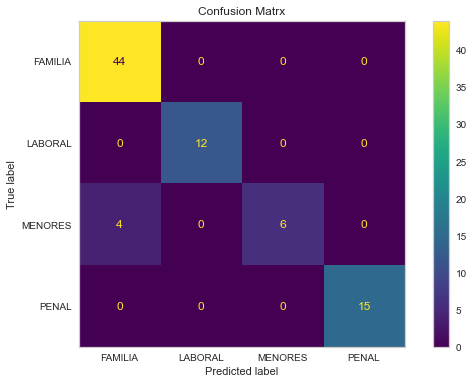

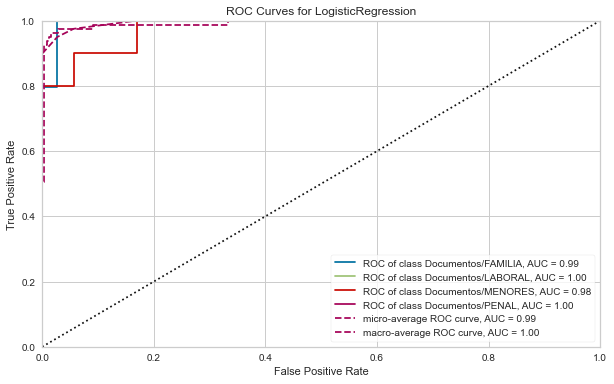

In [375]:
ltest = linear_model.LogisticRegression(multi_class= 'ovr',solver = 'liblinear',  penalty ='l2' , C = 1.0,random_state= seed)

test_model(ltest,X_train_counts, y_train, X_test_counts, y_test )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.92      1.00      0.96        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.60      0.75        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.95        81
         macro avg       0.98      0.90      0.93        81
      weighted avg       0.95      0.95      0.95        81



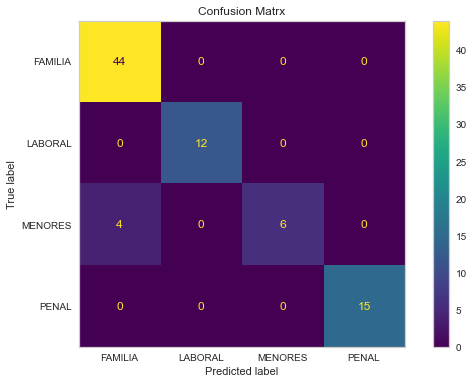

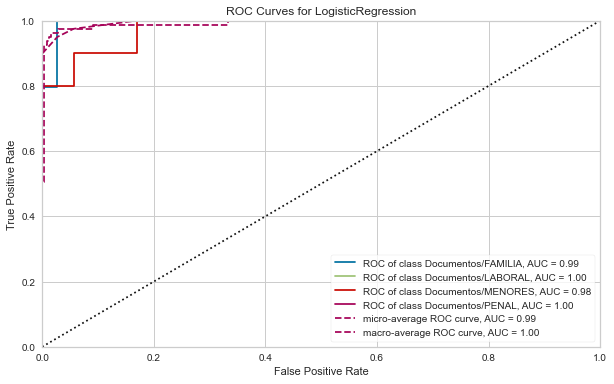

In [376]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear' , random_state = seed)

test_model(lm,X_train_counts, y_train, X_test_counts, y_test )

## Naive Bayes

Este modelo lo mostramos debido a que fué solicitado en el práctico. Pero aclaramos que el mismo, no quedó seleccionado entre los mejores modelos

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.72      1.00      0.84        44
Documentos/LABORAL       1.00      0.83      0.91        12
Documentos/MENORES       0.00      0.00      0.00        10
  Documentos/PENAL       1.00      0.67      0.80        15

          accuracy                           0.79        81
         macro avg       0.68      0.62      0.64        81
      weighted avg       0.73      0.79      0.74        81



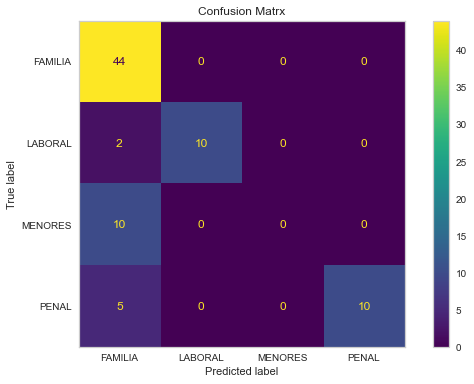

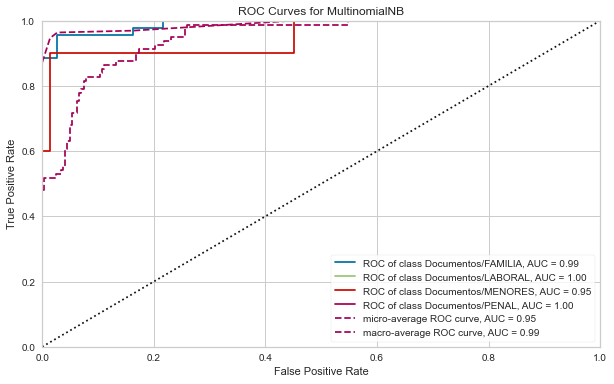

In [106]:
nb = MultinomialNB()
test_model(nb,X_train_counts, y_train, X_test_counts, y_test )

## SVM

In [381]:
rbf = svm.SVC(kernel='poly' , degree = 2, random_state = seed)

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.96      1.00      0.98        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.80      0.89        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.98        81
         macro avg       0.99      0.95      0.97        81
      weighted avg       0.98      0.98      0.97        81



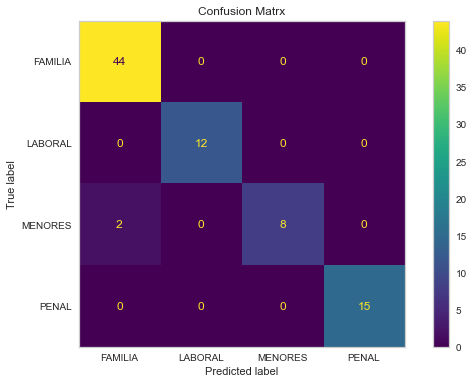

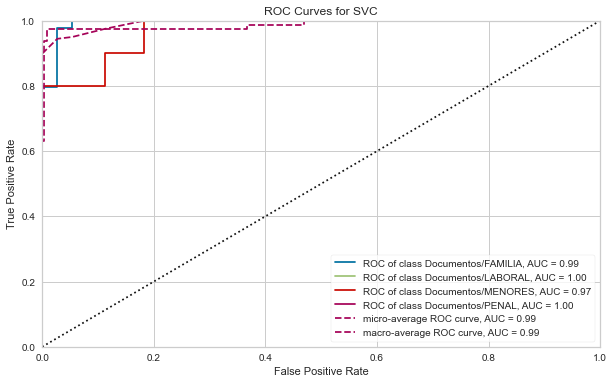

In [382]:
test_model(rbf,X_train_counts, y_train, X_test_counts, y_test )

In [383]:
poly = svm.SVC(kernel='rbf' , random_state = seed )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.96      1.00      0.98        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.80      0.89        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.98        81
         macro avg       0.99      0.95      0.97        81
      weighted avg       0.98      0.98      0.97        81



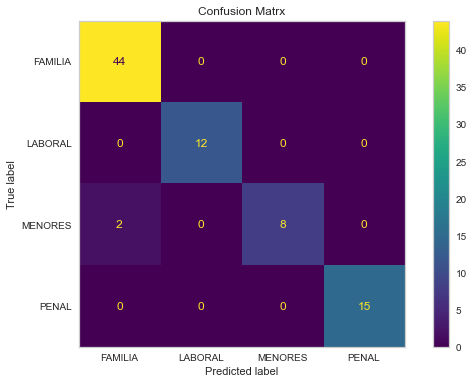

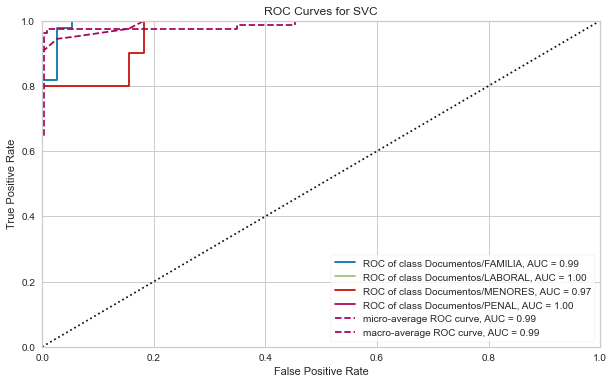

In [385]:
test_model(poly,X_train_counts, y_train, X_test_counts, y_test )

In [387]:
poly = svm.SVC(kernel='linear' , random_state = seed )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.95      0.97        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.82      0.90      0.86        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.96        81
         macro avg       0.95      0.96      0.96        81
      weighted avg       0.96      0.96      0.96        81



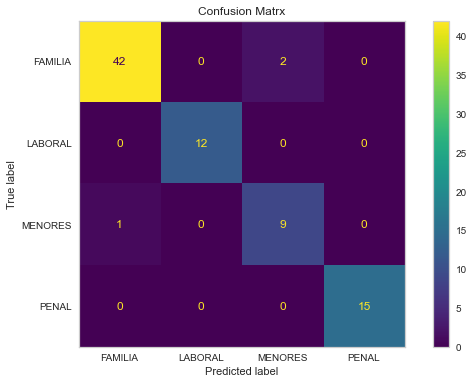

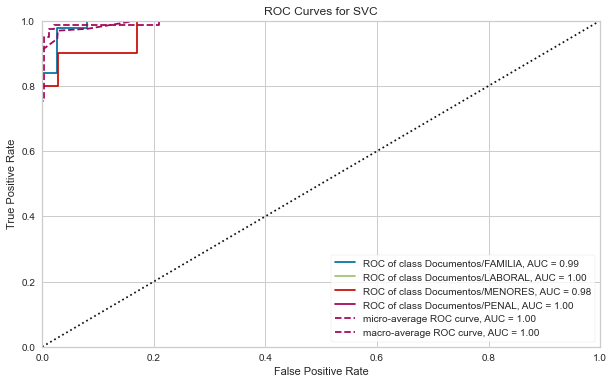

In [388]:
test_model(poly,X_train_counts, y_train, X_test_counts, y_test )

In [389]:
poly = svm.SVC(kernel='sigmoid' , random_state = seed )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.95      0.97        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.82      0.90      0.86        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.96        81
         macro avg       0.95      0.96      0.96        81
      weighted avg       0.96      0.96      0.96        81



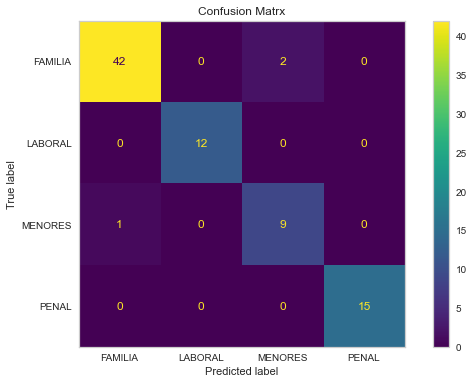

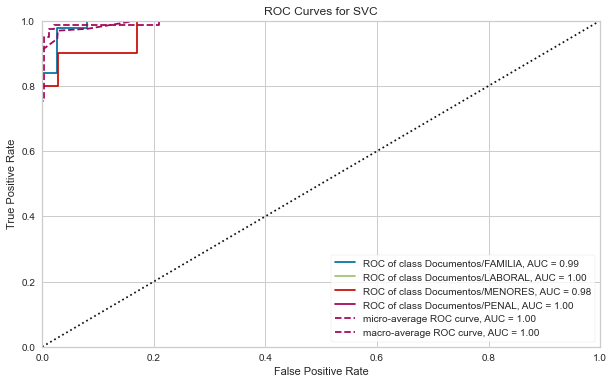

In [390]:
test_model(poly,X_train_counts, y_train, X_test_counts, y_test )

## Resultados

En líneas generales se observa un buen desempeño de todos los modelos, salvo el MultinomialNB. Este buen desempeño puede llegar a ser un overfitting. Quizás este comportamiento se debea a la poca cantidad de documentos y que además los documentos hayan sido generados por el mismo grupo de persona en cada fuero. Es decir, por ejemplo en el fuero penal, quizás los fallos pertenecen al mismo juez y han sido redactados por la misma persona. Esto indicaría un fuerte sesgo en el set de datos. Sugerimos contar con más fallos para poder aumentar el el set de datos y al mismo tiempo darle más variabilidad al mismo. En el caso de no contar con más fallos, se pueden recurrir a estrategias de aumentación de datos, por ejemplo: traducción bidireccional y/o generación de fallos aplicando sinónimos a los fallos existentes.
 

Si bien dentro de los modelos de clasificación solicitados, no estaba indicado RandomForest, lo hemos agregado al mismo en el Anexo. De todos los modelos, Random Forest fue el que mejor desempeño tuvo. 

Los mejores modelos y los respectivos híper parámetros encontrados son:

### RandomForest:

-	criterion: entropy
-	n_estimadors: 100
  

### RandomForest:

-	criterion: gini
-	n_estimadors: 100

### SVC:

-	kernel: poly
-	degree: 2

### SVC:

-	kernel: rbf

### SVC:

-	kernel: linear

### SVC:

-	kernel: sigmoid


### LogisticRegression


-	C: 1.0
-	multi_class: ovr
-	penalty: l2
-	solver: liblinear

En el apartado **Anexo**, punto *Optimización de modelos*, se puede observar los modelos que se probaron, los híper parámetros utilizados y los resultados obtenidos. 

In [363]:
document_id = 30
print (f"Label del documento {y_test.values[document_id]}")

Label del documento Documentos/FAMILIA


In [364]:
# El valor por defecto de n_estimatores es 100
rf_entropy = RandomForestClassifier(criterion = 'entropy') 
rf_entropy.fit(X_train_counts, y_train)

RandomForestClassifier(criterion='entropy')

In [365]:
print(f"Predicción {rf_entropy.predict(X_test_counts[document_id])}")

Predicción ['Documentos/FAMILIA']


In [366]:
rf_gini = RandomForestClassifier(criterion = 'gini') 
rf_gini.fit(X_train_counts, y_train)

RandomForestClassifier()

In [367]:
print(f"Predicción {rf_gini.predict(X_test_counts[document_id])}")

Predicción ['Documentos/FAMILIA']


In [368]:
svc_poly = svm.SVC(kernel = "poly" , degree = 3 )
svc_poly.fit(X_train_counts, y_train)

SVC(kernel='poly')

In [369]:
print(f"Predicción {svc_poly.predict(X_test_counts[document_id])}")

Predicción ['Documentos/FAMILIA']


In [370]:
svc_rbf = svm.SVC(kernel = "rbf" )
svc_rbf.fit(X_train_counts, y_train)

SVC()

In [371]:
print(f"Predicción {svc_rbf.predict(X_test_counts[document_id])}")

Predicción ['Documentos/FAMILIA']


# Anexo

## Optimización de modelos

Realizamos una implementación de gridsearch con cross validation, que permite pasar diferentes modelos de sickit-learn a ajustar. 
La idea es que este método nos permita hacer pruebas de manera sencilla de diferentes modelos con diferentes parámetros (GridSearchCV de sickit learn no permite hacer pruebas de diferentes modelos.). Luego en base a estos resultados, elegimos que modelos y parámetros presentar en el apartado * Clasificación usando diferentes modelos*

A la función **train_modelos** se le pasan:
-	 Dos diccionarios: los modelos y los parámetros.
-	 Los sets de entrenamiento y test
-	 La cantidad de folds

La función hace el entrenamiento de todos los modelos en base a los parámetros que se le indican y usando el CV indicado. Los resultados de la función son transformados a un data frame. Luego se puede ordenar el data frame por diferentes criterios (recall, f1-score, etc.)

Otra alternativa a esta implementación puede ser la indicada en http://www.davidsbatista.net/blog/2018/02/23/model_optimization/ . Preferimos implementar una versión propia para poder entender más profundamente los conceptos vistos en la diplomatura

In [361]:
models1 = {
    'RandomForset': RandomForestClassifier(),
    'MultinomialNB': MultinomialNB(),
    'SVM_01': svm.SVC(),
    'SVM_02': svm.SVC(),
    'LogisticRegressionClassifier': linear_model.LogisticRegression() ,
    'LogisticRegressionClassifier_01': linear_model.LogisticRegression()
    
}

params1 = {
    'RandomForset': {"n_estimators" : [100] , "criterion" : ["gini", "entropy"]},
    'LogisticRegressionClassifier': { "solver":["liblinear" , "sag", "saga","lbfgs"], "multi_class":["ovr"], "penalty":["l2" ] , "C": [1.0,0.7]  } ,
    'LogisticRegressionClassifier_01': { "solver":["liblinear" ], "multi_class":["ovr"], "penalty":["l2","l1"] , "C": [1.0,0.7,0.2]  } ,
    'SVM_01':{"kernel" :['poly'] , "degree" : [2,3,4,5] } ,
    'SVM_02':{"kernel" :['linear', 'rbf', 'sigmoid']  } ,
    'MultinomialNB':{"alpha" :[1.0] }
} 

# Esto se utiliza para hacer debug de la de la función. Se pone un solo modelo para que no tarde mucho
# la ejecución
models1T = {
    'SVM_01': svm.SVC(),
  
}

params1T = {
      #'SVM_01':{"kernel" :['linear', 'poly', 'rbf', 'sigmoid'] , "degree" : [3] } ,
    'SVM_01':{"kernel" :['rbf']  } ,
    
} 

In [362]:
from copy import copy, deepcopy



def roc_auc_score_macro(actual_class, pred_class, average = "macro"):

    roc_auc = roc_auc_score(actual_class, pred_class, average = average , multi_class ='ovr')
 
    return roc_auc



def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average , multi_class ='ovr')
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

#def train_model(model, folds_index, X_train, Y_train):

def generate_model_params(model_params):
    
    allNames = sorted(model_params)
    combinations = it.product(*(model_params[Name] for Name in allNames))
    return (list(combinations) , allNames)


def train_model(model_id, model, params_names, param_combination, folds_index, X_train, Y_train , X_test, Y_test , output_dict = True , random_state = None):
    
    param_combination = list(param_combination)
    print ("train model")
    print (f"{model} {params_names} {param_combination}")
   
    
    cloned_model = deepcopy(model)
    
    
    for param_name , param_value in zip(params_names,param_combination ):
        #print (f"{param_name} =  {param_value}")
        setattr(cloned_model , param_name , param_value)

    if type(random_state) == int:
        setattr(cloned_model , "random_state" , random_state)
        
    print (cloned_model)
    
    results = []
    
    for train_index, test_index in folds_index:
   
        cloned_model_tmp = deepcopy(cloned_model)
        #print (f"{train_index}")
        #print (f"{test_index}")
    
    
    #X_train, X_test, y_train, y_test
    
        # Se hace el split en base a los CV. Se obtienen los datos de X_train y de X_test con sus respectivos Y
        X_train_tmp, X_test_tmp = X_train[train_index], X_train[test_index]
        
        y_train_tmp, y_test_tmp = Y_train[train_index], Y_train[test_index] 
    
        cloned_model_tmp.fit(X_train_tmp,y_train_tmp)
       
    
        y_test_val_pred = cloned_model_tmp.predict(X_test_tmp)
        
        train_result = metrics.classification_report(y_test_tmp, y_test_val_pred , output_dict = output_dict )
        
        print(train_result)
        
        
        #roc_result = roc_auc_score(y_true = y_test_tmp, y_score = y_test_val_pred , multi_class = "ovr")
        
        roc_result = roc_auc_score_multiclass(actual_class=y_test_tmp, pred_class=y_test_val_pred)
        #roc_result_macro = roc_auc_score_macro(actual_class=y_test_tmp, pred_class=y_test_val_pred)
        
        
        results.append ((f"{model}","Train" , f"{params_names }", train_result , roc_result , f"{param_combination}" , model_id ))
    
    
    cloned_model_tmp = deepcopy(cloned_model)
    
    
    cloned_model_tmp.fit(X_train,Y_train)
        
    y_test_pred = cloned_model_tmp.predict(X_test)
    
    test_result = metrics.classification_report(Y_test, y_test_pred , output_dict = output_dict )
    
    #roc_result = roc_auc_score(y_true = Y_test, y_score = y_test_pred , multi_class = "ovr")
    roc_result = roc_auc_score_multiclass(actual_class=Y_test, pred_class=y_test_pred)
    #roc_result_macro = roc_auc_score_macro(actual_class=y_test_tmp, pred_class=y_test_val_pred)
        
    results.append ((f"{model}","Test", f"{params_names} ", test_result , roc_result , f"{param_combination}" , f"{model_id}" ))
    
    print("Test")
    print(test_result)
    
    return results
    

def sum_train_values(results):

    
   
    total = (0,0,0)
    
    for model_result in results:
            total = (total[0] + model_result[3]['macro avg']['precision'] , total[1] + model_result[3]['macro avg']['recall'],total [2] + model_result[3]['macro avg']['recall'])

    #total = total / len (results)
    cantidad_filas = len (results)
    
    total = (total[0] / cantidad_filas, total[1] / cantidad_filas, total[2] / cantidad_filas)
    print ("Ponderado")
    print (f"{total}")
    
    
    
    return total

def train_models(X_train,Y_train,X_test, Y_test, cv=5,shuffle=True, models=None ,params=None , output_dict = True , random_state = None):
    
    results = []
    
    kf = KFold(n_splits=cv, random_state=random_state, shuffle=shuffle )
   
    model_id = 0 
    
    folds_index = [(train_index, test_index) for train_index, test_index in kf.split(X_train)  ]

    for param_model in params.keys():
    
        params_combination, params_names = generate_model_params(params.get(param_model))
        #print (f"Modelo a ejecutar: {param_model}, parámetros a probar: {params_combination} , nombre de los parámetros: {params_names} ")
        
        for param_combination in params_combination:
            #print (f"{param_model}: {param_combination} ")
            
            model_result = train_model(model_id = model_id, model = models.get(param_model),params_names = params_names, param_combination = param_combination, folds_index = folds_index, X_train = X_train, Y_train = Y_train , X_test = X_test, Y_test = Y_test , output_dict = output_dict , random_state = random_state )     
            
         
            results.extend( model_result  )
    
    
        model_id = model_id + 1  

    return results        
       

In [355]:
#y_train.values

Esta función arma un data frame con el resultado de los entrenamientos. Notar que para calcular el ROC_AUC, se hace una suma de los valores ponderados del ROC_AUC por clase. Notar que el valor ROC_AUC que se obtiene acá es diferente al que se muestran en los diagramas. Esto se debe a que en esta función estamos calculando el ROC_AUC ponderado, mientras que en la librería yellowbrick, se hace el calculo de la ROC_AUC micro y macro que usa otro criterio (ver https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html). Nos parece más conveniente el criterio que planteamos nosotros.

In [356]:
def toDataFrame(results, y_test):
    
    counter = Counter(y_test)
    total = counter['Documentos/FAMILIA'] + counter['Documentos/LABORAL'] + counter['Documentos/MENORES'] + counter['Documentos/PENAL']
    familia = counter['Documentos/FAMILIA'] / total
    laboral = counter['Documentos/LABORAL'] / total
    menores = counter['Documentos/MENORES'] / total
    penal = counter['Documentos/PENAL'] / total
    
    print ("Ponderado fuero")
    print (f"familia: {familia}, laboral: {laboral}, menores: {menores}, penal: {penal} ")
    
    filtered_values =  []
    columns = ["id", "modelo", "modo" , "parametros" , "valores" , "accuracy", "precision" , "recall" , "f1-score" , "roc_penal", "roc_familia" ,"roc_laboral" , "roc_menores" ,]
    for result in results:
        #print (f"{result[0]} {result[1]} {result[2]} {result[3]['macro avg']} \n")
        filtered_values.append(( result[6], result[0], result[1] , result[2] , result[5] , result[3]['accuracy'], result[3]['macro avg']['precision'] , result[3]['macro avg']['recall'] ,  result[3]['macro avg']['f1-score'] , result[4]["Documentos/PENAL"] , result[4]["Documentos/FAMILIA"] , result[4]["Documentos/LABORAL"] , result[4]["Documentos/MENORES"]))

    df= pd.DataFrame(data = filtered_values , columns = columns)
    
    df["roc_ponderado"] = (df["roc_penal"] * penal + df["roc_familia"] * familia + df["roc_laboral"] * laboral + df["roc_menores"] * menores)
    return df

In [357]:
results  = train_models(X_train= X_train_counts, Y_train =y_train.values ,  X_test = X_test_counts, Y_test = y_test.values,  models = models1 , params = params1 , cv=5 , output_dict = True , random_state = seed )

train model
RandomForestClassifier() ['criterion', 'n_estimators'] ['gini', 100]
RandomForestClassifier(random_state=42)
{'Documentos/FAMILIA': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, 'accuracy': 0.9696969696969697, 'macro avg': {'precision': 0.984375, 'recall': 0.9166666666666666, 'f1-score': 0.9419354838709677, 'support': 33}, 'weighted avg': {'precision': 0.9715909090909091, 'recall': 0.9696969696969697, 'f1-score': 0.9671554252199412, 'support': 33}}
{'Documentos/FAMILIA': {'precision': 0.9565217391304348, 'recall': 1.0, 'f1-score': 0.9777777777777777, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/

Test
{'Documentos/FAMILIA': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'accuracy': 0.9506172839506173, 'macro avg': {'precision': 0.9791666666666666, 'recall': 0.9, 'f1-score': 0.9266304347826086, 'support': 81}, 'weighted avg': {'precision': 0.9547325102880658, 'recall': 0.9506172839506173, 'f1-score': 0.9455179817498658, 'support': 81}}
train model
LogisticRegression() ['C', 'multi_class', 'penalty', 'solver'] [1.0, 'ovr', 'l2', 'sag']
LogisticRegression(multi_class='ovr', random_state=42, solver='sag')
{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision':

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.9583333333333334, 'recall': 0.7976190476190477, 'f1-score': 0.833041958041958, 'support': 33}, 'weighted avg': {'precision': 0.9242424242424242, 'recall': 0.9090909090909091, 'f1-score': 0.8969061241788514, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9393939393939394, 'macro avg': {'precision': 0.9791666666666666, 'recall': 0.8333333333333334, 'f1-score': 0.8641304347826086, 'support': 33}, 'weighted avg': {'precision': 0.9444444444444444, 'recall': 0.9393939393939394, 'f1-score': 0.9255599472990778, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.7894736842105263, 'recall': 1.0, 'f1-score': 0.8823529411764706, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'accuracy': 0.875, 'macro avg': {'precision': 0.9473684210526316, 'recall': 0.78125, 'f1-score': 0.803921568627451, 'support': 32}, 'weighted avg': {'precision': 0.9013157894736843, 'recall': 0.875, 'f1-score': 0.853186274509804, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.9285714285714286, 'recall': 1.0, 'f1-score': 0.962962962962963, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'accuracy': 0.96875, 'macro avg': {'precision': 0.9821428571428572, 'recall': 0.9166666666666666, 'f1-score': 0.9407407407407408, 'support': 32}, 'weighted avg': {'precision': 0.9709821428571428, 'recall': 0.96875, 'f1-score': 0.9662037037037037, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9}, 'accuracy': 0.90625, 'macro avg': {'precision': 0.9583333333333334, 'recall': 0.875, 'f1-score': 0.8939393939393939, 'support': 32}, 'weighted avg': {'precision': 0.921875, 'recall': 0.90625, 'f1-score': 0.8948863636363636, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test
{'Documentos/FAMILIA': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.6, 'f1-score': 0.7499999999999999, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'accuracy': 0.9506172839506173, 'macro avg': {'precision': 0.9791666666666666, 'recall': 0.9, 'f1-score': 0.9266304347826086, 'support': 81}, 'weighted avg': {'precision': 0.9547325102880658, 'recall': 0.9506172839506173, 'f1-score': 0.9455179817498658, 'support': 81}}
train model
LogisticRegression() ['C', 'multi_class', 'penalty', 'solver'] [1.0, 'ovr', 'l2', 'lbfgs']
LogisticRegression(multi_class='ovr', random_state=42)
{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recal

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
{'Documentos/FAMILIA': {'precision': 0.8627450980392157, 'recall': 1.0, 'f1-score': 0.9263157894736842, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3, 'f1-score': 0.4615384615384615, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'accuracy': 0.9135802469135802, 'macro avg': {'precision': 0.9656862745098039, 'recall': 0.825, 'f1-score': 0.8469635627530364, 'support': 81}, 'weighted avg': {'precision': 0.925441781650932, 'recall': 0.9135802469135802, 'f1-score': 0.8934972759534162, 'support': 81}}
train model
LogisticRegression() ['C', 'multi_class', 'penalty', 'solver'] [0.7, 'ovr', 'l2', 'sag']
LogisticRegression(C=0.7, multi_class='ovr', random_state=42, solver='sag')
{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'pre

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.88, 'recall': 1.0, 'f1-score': 0.9361702127659575, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.72, 'recall': 0.75, 'f1-score': 0.7340425531914894, 'support': 33}, 'weighted avg': {'precision': 0.8290909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.8665377176015473, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'accuracy': 0.84375, 'macro avg': {'precision': 0.6875, 'recall': 0.71875, 'f1-score': 0.6976190476190476, 'support': 32}, 'weighted avg': {'precision': 0.7578125, 'recall': 0.84375, 'f1-score': 0.7913690476190476, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.8125, 'recall': 1.0, 'f1-score': 0.896551724137931, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'accuracy': 0.90625, 'macro avg': {'precision': 0.703125, 'recall': 0.75, 'f1-score': 0.7241379310344828, 'support': 32}, 'weighted avg': {'precision': 0.830078125, 'recall': 0.90625, 'f1-score': 0.8642241379310345, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.6818181818181818, 'recall': 1.0, 'f1-score': 0.8108108108108109, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, 'support': 9}, 'accuracy': 0.78125, 'macro avg': {'precision': 0.6704545454545454, 'recall': 0.7222222222222222, 'f1-score': 0.6879968203497615, 'support': 32}, 'weighted avg': {'precision': 0.6633522727272727, 'recall': 0.78125, 'f1-score': 0.7072734499205088, 'support': 32}}
Test
{'Documentos/FAMILIA': {'precision': 0.8627450980392157, 'recall': 1.0, 'f1-score': 0.9263157894736842, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3, 'f1-score': 0.4615384615384615, 'support': 10}, 'Docume

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.9583333333333334, 'recall': 0.7976190476190477, 'f1-score': 0.833041958041958, 'support': 33}, 'weighted avg': {'precision': 0.9242424242424242, 'recall': 0.9090909090909091, 'f1-score': 0.8969061241788514, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

{'Documentos/FAMILIA': {'precision': 0.88, 'recall': 1.0, 'f1-score': 0.9361702127659575, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.72, 'recall': 0.75, 'f1-score': 0.7340425531914894, 'support': 33}, 'weighted avg': {'precision': 0.8290909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.8665377176015473, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Documentos/FAMILIA': {'precision': 0.7894736842105263, 'recall': 1.0, 'f1-score': 0.8823529411764706, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'accuracy': 0.875, 'macro avg': {'precision': 0.9473684210526316, 'recall': 0.78125, 'f1-score': 0.803921568627451, 'support': 32}, 'weighted avg': {'precision': 0.9013157894736843, 'recall': 0.875, 'f1-score': 0.853186274509804, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

{'Documentos/FAMILIA': {'precision': 0.8125, 'recall': 1.0, 'f1-score': 0.896551724137931, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'accuracy': 0.90625, 'macro avg': {'precision': 0.703125, 'recall': 0.75, 'f1-score': 0.7241379310344828, 'support': 32}, 'weighted avg': {'precision': 0.830078125, 'recall': 0.90625, 'f1-score': 0.8642241379310345, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

{'Documentos/FAMILIA': {'precision': 0.6818181818181818, 'recall': 1.0, 'f1-score': 0.8108108108108109, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, 'support': 9}, 'accuracy': 0.78125, 'macro avg': {'precision': 0.6704545454545454, 'recall': 0.7222222222222222, 'f1-score': 0.6879968203497615, 'support': 32}, 'weighted avg': {'precision': 0.6633522727272727, 'recall': 0.78125, 'f1-score': 0.7072734499205088, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test
{'Documentos/FAMILIA': {'precision': 0.8627450980392157, 'recall': 1.0, 'f1-score': 0.9263157894736842, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3, 'f1-score': 0.4615384615384615, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'accuracy': 0.9135802469135802, 'macro avg': {'precision': 0.9656862745098039, 'recall': 0.825, 'f1-score': 0.8469635627530364, 'support': 81}, 'weighted avg': {'precision': 0.925441781650932, 'recall': 0.9135802469135802, 'f1-score': 0.8934972759534162, 'support': 81}}
train model
LogisticRegression() ['C', 'multi_class', 'penalty', 'solver'] [0.7, 'ovr', 'l2', 'lbfgs']
LogisticRegression(C=0.7, multi_class='ovr', random_state=42)
{'Documentos/FAMILIA': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.88, 'recall': 1.0, 'f1-score': 0.9361702127659575, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.72, 'recall': 0.75, 'f1-score': 0.7340425531914894, 'support': 33}, 'weighted avg': {'precision': 0.8290909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.8665377176015473, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'accuracy': 0.84375, 'macro avg': {'precision': 0.6875, 'recall': 0.71875, 'f1-score': 0.6976190476190476, 'support': 32}, 'weighted avg': {'precision': 0.7578125, 'recall': 0.84375, 'f1-score': 0.7913690476190476, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.8125, 'recall': 1.0, 'f1-score': 0.896551724137931, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'accuracy': 0.

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.6818181818181818, 'recall': 1.0, 'f1-score': 0.8108108108108109, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, 'support': 9}, 'accuracy': 0.78125, 'macro avg': {'precision': 0.6704545454545454, 'recall': 0.7222222222222222, 'f1-score': 0.6879968203497615, 'support': 32}, 'weighted avg': {'precision': 0.6633522727272727, 'recall': 0.78125, 'f1-score': 0.7072734499205088, 'support': 32}}
Test
{'Documentos/FAMILIA': {'precision': 0.8627450980392157, 'recall': 1.0, 'f1-score': 0.9263157894736842, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3, 'f1-score': 0.4615384615384615, 'support': 10}, 'Docume

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9}, 'accuracy': 0.8125, 'macro avg': {'precision': 0.6785714285714286, 'recall': 0.75, 'f1-score': 0.7083333333333333, 'support': 32}, 'weighted avg': {'precision': 0.6785714285714286, 'recall': 0.8125, 'f1-score': 0.734375, 'support': 32}}
Test
{'Documentos/FAMILIA': {'precision': 0.8571428571428571, 'recall': 0.9545454545454546, 'f1-score': 0.9032258064516128, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'Documentos/MENORES': {'precision': 0.7142857142857143, 'recall': 0.5, 'f1-score': 0.588235294117647, 'support': 10}, 'Documentos/PENAL': {'precision': 

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.88, 'recall': 1.0, 'f1-score': 0.9361702127659575, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.72, 'recall': 0.75, 'f1-score': 0.7340425531914894, 'support': 33}, 'weighted avg': {'precision': 0.8290909090909091, 'recall': 0.9090909090909091, 'f1-score': 0.8665377176015473, 'support': 33}}
{'Documentos/FAMILIA': {'precision': 0.7894736842105263, 'recall': 1.0, 'f1-score': 0.8823529411764706, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-sco

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'accuracy': 0.8484848484848485, 'macro avg': {'precision': 0.6875, 'recall': 0.6830357142857143, 'f1-score': 0.6783882783882784, 'support': 33}, 'weighted avg': {'precision': 0.7954545454545454, 'recall': 0.8484848484848485, 'f1-score': 0.8116772116772116, 'support': 33}}
{'Documentos/FAMILIA': {'precision': 0.8461538461538461, 'recall': 1.0, 'f1-score': 0.9166666666666666, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.8125, 'recall': 1.0, 'f1-score': 0.896551724137931, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'accuracy': 0.90625, 'macro avg': {'precision': 0.703125, 'recall': 0.75, 'f1-score': 0.7241379310344828, 'support': 32}, 'weighted avg': {'precision': 0.830078125, 'recall': 0.90625, 'f1-score': 0.8642241379310345, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.6818181818181818, 'recall': 1.0, 'f1-score': 0.8108108108108109, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, '

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.43333333333333335, 'recall': 1.0, 'f1-score': 0.6046511627906976, 'support': 13}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.2, 'f1-score': 0.33333333333333337, 'support': 10}, 'accuracy': 0.46875, 'macro avg': {'precision': 0.35833333333333334, 'recall': 0.3, 'f1-score': 0.23449612403100775, 'support': 32}, 'weighted avg': {'precision': 0.48854166666666665, 'recall': 0.46875, 'f1-score': 0.3498062015503876, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.7142857142857143, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.33

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.40625, 'recall': 1.0, 'f1-score': 0.5777777777777777, 'support': 13}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'accuracy': 0.40625, 'macro avg': {'precision': 0.1015625, 'recall': 0.25, 'f1-score': 0.14444444444444443, 'support': 32}, 'weighted avg': {'precision': 0.1650390625, 'recall': 0.40625, 'f1-score': 0.2347222222222222, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.46875, 'recall': 1.0, 'f1-score': 0.6382978723404256, 'support': 15}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/PENAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.46875, '

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.8148148148148148, 'recall': 1.0, 'f1-score': 0.8979591836734693, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 6}, 'accuracy': 0.8484848484848485, 'macro avg': {'precision': 0.7037037037037037, 'recall': 0.6666666666666666, 'f1-score': 0.6744897959183673, 'support': 33}, 'weighted avg': {'precision': 0.7856341189674523, 'recall': 0.8484848484848485, 'f1-score': 0.804700061842919, 'support': 33}}
{'Documentos/FAMILIA': {'precision': 0.7894736842105263, 'recall': 1.0, 'f1-score': 0.8823529411764706, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'suppo

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.7096774193548387, 'recall': 1.0, 'f1-score': 0.8301886792452831, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'accuracy': 0.7272727272727273, 'macro avg': {'precision': 0.4274193548387097, 'recall': 0.5, 'f1-score': 0.45754716981132076, 'support': 33}, 'weighted avg': {'precision': 0.533724340175953, 'recall': 0.7272727272727273, 'f1-score': 0.614065180102916, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222222222222, 'support': 8}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.2, 'f1-score': 0.33333333333333337, 'support': 5}, 'accuracy': 0.53125, 'macro avg': {'precision': 0.625, 'recall': 0.33125, 'f1-score': 0.3055555555555556, 'support': 32}, 'weighted avg': {'precision': 0.640625, 'recall': 0.53125, 'f1-score': 0.42013888888888895, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.48148148148148145, 'recall': 1.0, 'f1-score': 0.65, 'support': 13}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 6}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.2, 'f1

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
{'Documentos/FAMILIA': {'precision': 0.6567164179104478, 'recall': 1.0, 'f1-score': 0.7927927927927928, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.5833333333333334, 'f1-score': 0.7368421052631579, 'support': 12}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.4666666666666667, 'f1-score': 0.6363636363636364, 'support': 15}, 'accuracy': 0.7160493827160493, 'macro avg': {'precision': 0.664179104477612, 'recall': 0.5125000000000001, 'f1-score': 0.5414996336048967, 'support': 81}, 'weighted avg': {'precision': 0.6900681776303667, 'recall': 0.7160493827160493, 'f1-score': 0.6576597863147571, 'support': 81}}
train model
SVC() ['degree', 'kernel'] [5, 'poly']
SVC(degree=5, kernel='poly', random_state=42)
{'Documentos/FAMILIA': {'precision': 0.45454545454545453, 'recall': 1.0, 'f1-score': 0.625, 'support': 15}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-s

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.6875, 'recall': 1.0, 'f1-score': 0.8148148148148148, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 2}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'Documentos/PENAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'accuracy': 0.696969696969697, 'macro avg': {'precision': 0.421875, 'recall': 0.375, 'f1-score': 0.37037037037037035, 'support': 33}, 'weighted avg': {'precision': 0.5189393939393939, 'recall': 0.696969696969697, 'f1-score': 0.5836139169472502, 'support': 33}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.4838709677419355, 'recall': 1.0, 'f1-score': 0.6521739130434783, 'support': 15}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.2, 'f1-score': 0.33333333333333337, 'support': 5}, 'accuracy': 0.5, 'macro avg': {'precision': 0.3709677419354839, 'recall': 0.3, 'f1-score': 0.2463768115942029, 'support': 32}, 'weighted avg': {'precision': 0.38306451612903225, 'recall': 0.5, 'f1-score': 0.35778985507246375, 'support': 32}}


/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

{'Documentos/FAMILIA': {'precision': 0.41935483870967744, 'recall': 1.0, 'f1-score': 0.5909090909090909, 'support': 13}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, 'Documentos/PENAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'accuracy': 0.4375, 'macro avg': {'precision': 0.3548387096774194, 'recall': 0.3333333333333333, 'f1-score': 0.2727272727272727, 'support': 32}, 'weighted avg': {'precision': 0.2641129032258065, 'recall': 0.4375, 'f1-score': 0.28693181818181823, 'support': 32}}
{'Documentos/FAMILIA': {'precision': 0.4838709677419355, 'recall': 1.0, 'f1-score': 0.6521739130434783, 'support': 15}, 'Documentos/LABORAL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.16666666666666666, 'f1-score': 0.2857142857142857, 'support': 6}, 'Documentos/

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test
{'Documentos/FAMILIA': {'precision': 0.5866666666666667, 'recall': 1.0, 'f1-score': 0.7394957983193278, 'support': 44}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 0.16666666666666666, 'f1-score': 0.2857142857142857, 'support': 12}, 'Documentos/MENORES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 0.26666666666666666, 'f1-score': 0.4210526315789474, 'support': 15}, 'accuracy': 0.6172839506172839, 'macro avg': {'precision': 0.6466666666666667, 'recall': 0.35833333333333334, 'f1-score': 0.3615656789031402, 'support': 81}, 'weighted avg': {'precision': 0.6520164609053498, 'recall': 0.6172839506172839, 'f1-score': 0.5220021731889637, 'support': 81}}
train model
SVC() ['kernel'] ['linear']
SVC(kernel='linear', random_state=42)
{'Documentos/FAMILIA': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'sup

{'Documentos/FAMILIA': {'precision': 0.9565217391304348, 'recall': 1.0, 'f1-score': 0.9777777777777777, 'support': 22}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 3}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}, 'accuracy': 0.9696969696969697, 'macro avg': {'precision': 0.9891304347826086, 'recall': 0.9166666666666666, 'f1-score': 0.9444444444444444, 'support': 33}, 'weighted avg': {'precision': 0.9710144927536231, 'recall': 0.9696969696969697, 'f1-score': 0.967003367003367, 'support': 33}}
{'Documentos/FAMILIA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'Documentos/LABORAL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, 'Documentos/MENORES': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4}, 'Documentos/PENAL': {'precision': 1.0, 'recall': 1.0,

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [358]:
result_logistic = toDataFrame(results , y_test.values)

Ponderado fuero
familia: 0.5432098765432098, laboral: 0.14814814814814814, menores: 0.12345679012345678, penal: 0.18518518518518517 


### Ordenamos los modelos (y los parámetros utilizados) según diferentes métricas

#### TEST: f1-score y accuracy 

Al ser ser un data set desbalanceado, tomamos el los mejores f1-score. El accuracy al ser un data set desbalanceado no es recomendable utilizarlo.

In [359]:
result_logistic[result_logistic["modo"] =="Test"].sort_values(by=['accuracy','f1-score'] , ascending = False)

,id,modelo,modo,parametros,valores,accuracy,precision,recall,f1-score,roc_penal,roc_familia,roc_laboral,roc_menores,roc_ponderado
11,0,RandomForestClassifier(),Test,"['criterion', 'n_estimators']","['entropy', 100]",0.987654,0.994444,0.975000,0.984033,1.000000,0.986486,1.000000,0.950000,0.986486
5,0,RandomForestClassifier(),Test,"['criterion', 'n_estimators']","['gini', 100]",0.975309,0.969318,0.969318,0.969318,1.000000,0.975123,1.000000,0.942958,0.979444
101,3,SVC(),Test,"['degree', 'kernel']","[2, 'poly']",0.975309,0.989130,0.950000,0.966667,1.000000,0.972973,1.000000,0.900000,0.972973
131,4,SVC(),Test,['kernel'],['rbf'],0.975309,0.989130,0.950000,0.966667,1.000000,0.972973,1.000000,0.900000,0.972973
125,4,SVC(),Test,['kernel'],['linear'],0.962963,0.948732,0.963636,0.955665,1.000000,0.963759,1.000000,0.935915,0.972402
137,4,SVC(),Test,['kernel'],['sigmoid'],0.950617,0.931548,0.957955,0.942918,1.000000,0.952396,1.000000,0.928873,0.965360
17,1,LogisticRegression(),Test,"['C', 'multi_class', 'penalty', 'solver']","[1.0, 'ovr', 'l2', 'liblinear']",0.950617,0.979167,0.900000,0.926630,1.000000,0.945946,1.000000,0.800000,0.945946
23,1,LogisticRegression(),Test,"['C', 'multi_class', 'penalty', 'solver']","[1.0, 'ovr', 'l2', 'sag']",0.950617,0.979167,0.900000,0.926630,1.000000,0.945946,1.000000,0.800000,0.945946
29,1,LogisticRegression(),Test,"['C', 'multi_class', 'penalty', 'solver']","[1.0, 'ovr', 'l2', 'saga']",0.950617,0.979167,0.900000,0.926630,1.000000,0.945946,1.000000,0.800000,0.945946
35,1,LogisticRegression(),Test,"['C', 'multi_class', 'penalty', 'solver']","[1.0, 'ovr', 'l2', 'lbfgs']",0.950617,0.979167,0.900000,0.926630,1.000000,0.945946,1.000000,0.800000,0.945946


#### Train: f1-score y accuracy 

Al ser ser un data set desbalanceado, tomamos el los mejores f1-score. **Notar que se hace un promedio por modelo**. Es decir se hace un promedio
resultado de aplicar todas las convinaciones de parametros por modelo


In [360]:
result_train = result_logistic[result_logistic["modo"] !="Test"]

result_train.groupby(['id']).mean().sort_values(['f1-score' ,'accuracy'], ascending=False)


,accuracy,precision,recall,f1-score,roc_penal,roc_familia,roc_laboral,roc_menores,roc_ponderado
id,,,,,,,,,
0,0.975379,0.988451,0.945833,0.962362,1.000000,0.973589,1.000000,0.891667,0.972279
4,0.975505,0.989298,0.945536,0.959901,1.000000,0.972628,0.991071,0.900000,0.971463
1,0.891667,0.867654,0.789038,0.796985,0.994444,0.891411,0.973214,0.610417,0.887920
2,0.771117,0.649828,0.634049,0.614356,0.860401,0.776322,0.846189,0.561111,0.775673
3,0.718703,0.718092,0.595799,0.592381,0.728056,0.720721,0.813542,0.650000,0.727099
5,0.665530,0.550492,0.521806,0.492194,0.826944,0.685644,0.716667,0.500000,0.693488


## Random Forest

Si bien el modelo de clasificación random forest no fue solicitado, lo agregamos debido a que los métodos desarrollados nos permiten de una forma sencilla entrenar modelos y visualizar los resultados

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      1.00      0.99        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       1.00      0.90      0.95        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.99        81
         macro avg       0.99      0.97      0.98        81
      weighted avg       0.99      0.99      0.99        81



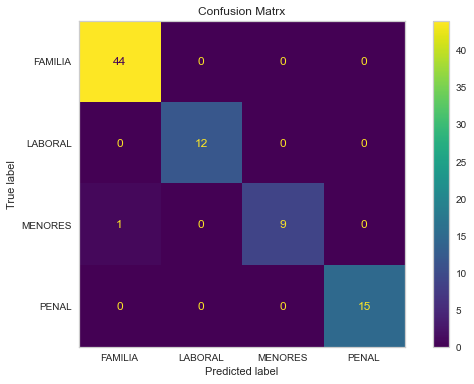

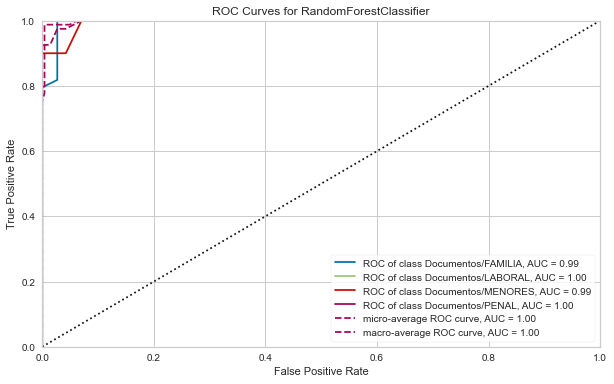

In [372]:
randomForest = RandomForestClassifier(criterion="entropy" , random_state = seed)
test_model(randomForest,X_train_counts, y_train, X_test_counts, y_test )

                    precision    recall  f1-score   support

Documentos/FAMILIA       0.98      0.98      0.98        44
Documentos/LABORAL       1.00      1.00      1.00        12
Documentos/MENORES       0.90      0.90      0.90        10
  Documentos/PENAL       1.00      1.00      1.00        15

          accuracy                           0.98        81
         macro avg       0.97      0.97      0.97        81
      weighted avg       0.98      0.98      0.98        81



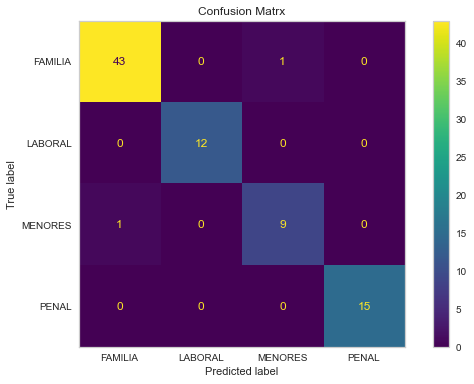

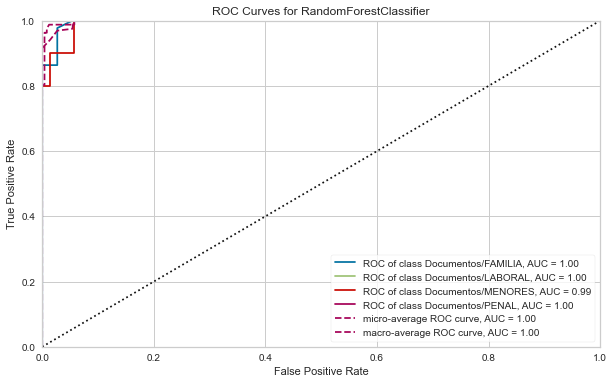

In [373]:
randomForest = RandomForestClassifier(criterion="gini" , random_state = seed)
test_model(randomForest,X_train_counts, y_train, X_test_counts, y_test )